# Lập trình Bootstrap với Python

## Bài 1: Kỹ thuật chọn mẫu ngẫu nhiên có hoàn lại

**BS. Lê Ngọc Khả Nhi

# Giới thiệu

Bootstrap là tập hợp một số kỹ thuật suy diễn thống kê dựa trên nguyên lý tái chọn mẫu có hoàn lại (resampling with replacement),được nhà thống kê Bradley Efron (1938-) phát triển trong giai đoạn từ năm 1979 đến 1987. Phương pháp này từng được xem như một cuộc cách mạng trong thống kê vì hiệu quả rất cao của nó, và được áp dụng phổ biến trong phân tích thống kê quy ước.

Tuy rất hữu ích, nhưng bootstrap không không dễ tiếp cận - ngay cả với một số phần mềm thống kê thương mại như IBM-SPSS, chỉ có gói tính năng nâng cao mới được tích hợp quy trình Bootstrap, gói cơ bản không hõ trợ tính năng này. Khi dùng ngôn ngữ lập trình thống kê R, người dùng phải biết sử dụng một số thư viện chuyên biệt để thực hiện Bootstrap. Còn với Python ? Không có thư viện nào cả và bạn sẽ phải tự code mọi thứ một cách hoàn toàn thủ công. Do đó, Nhi quyết định thực hiện series bài thực hành chuyên đề lập trình Bootstrap dành cho các bạn dùng ngôn ngữ Python.


# Cấu tạo một chương trình bootstrap

Một quy trình Bootstrap trong Python gồm những công đoạn chính sau đây:

1. Sử dụng một cơ chế sinh số giả ngẫu nhiên (Pseudorandom number generator) để sinh ra một mẫu ngẫu nhiên có hoàn lại từ dữ liệu gốc, và có kích thước đúng bằng với kích thước dữ liệu gốc.

2. Áp dụng 1 hàm thống kê mục tiêu (target function), cho phép uớc tính một chỉ số thống kê từ dữ liệu đầu vào là mẫu ngẫu nhiên vừa được sinh ra trong bước 1 (thí dụ: trung bình, trung vị, hệ số tương quan...)

3. Lặp lại 2 bước trên rất nhiều lượt (thường lớn hơn 1000), mỗi lần lưu kết quả vào một cấu trúc dữ liệu (list, array, tensor, dictionary...).

4. Thực hiện suy diễn thống kê trên dữ liệu kết quả từ bước 3, thí dụ khoảng tin cậy (CI), khoảng tin cậy có hiệu chỉnh bias-corrected and accelerated (BCa), kiểm định thống kê hoán vị (permutation test)... 

# Quy trình sinh mẫu ngẫu nhiên

Như ta thấy, bộ phận cơ bản và thiết yếu cho quy trình Bootstrap chính là một cơ chế để sinh mẫu ngẫu nhiên. Dữ liệu đầu vào của quy trình này thường là 1 list, array hoặc tensor, tùy thư viện mà ta dùng. Dữ liệu đầu ra là một cấu trúc dữ liệu tương đồng, cùng kích thước nhưng thành phần bên trong được rút ngẫu nhiên có hoàn lại từ dữ liệu gốc.

Trong bài đầu tiên này Nhi sẽ giới thiệu với các bạn tất cả giải pháp mà Nhi biết để tiến hành quy trình sinh mẫu ngẫu nhiên này, bao gồm:

1) Sử dụng module random mặc định của Python;

2) Sử numpy array (CPU)

3) Sử dụng GPU (cupy array, tensorflow và pytorch tensors)

4) Sử dụng thư viện cấp cao: pandas.Series và pandas.DataFrame

In [5]:
import numpy as np
import cupy as cp
import torch
import tensorflow as tf
import pandas as pd
import random
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

Nhi chuẩn bị 1 hàm để vẽ histogram khảo sát dữ liệu, nó sẽ cho ta biết cấu trúc bên trong của mẫu đã bị xáo trộn đến mức nào...

In [22]:
def histogram(data: np.array, bins=50):
    
    plt.rcParams["figure.figsize"] = (20,3)
    cm = plt.cm.get_cmap('RdYlGn')
    
    plt.rcParams["figure.figsize"] = (6,2)

    n, bins, patches = plt.hist(data, bins = bins)
    bin_centers = 1 * (bins[:-1] + bins[1:])
    col = bin_centers - min(bin_centers)
    col /= max(col)
    
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    plt.show()

Dữ liệu gốc của chúng ta là 1 list gồm 100 con số từ 0 đến 99

In [36]:
x = list(range(100))

print(x)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


Như vậy, mỗi phần tử trong x chỉ xuất hiện 1 lần, histogram có hình ảnh đồng dạng như sau:

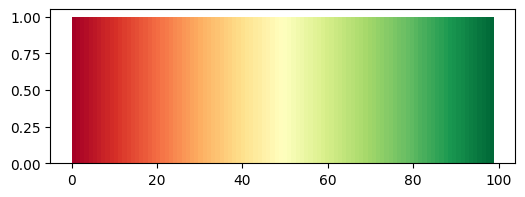

In [25]:
histogram(data = x, bins=len(x))

# Python random

**random.randint**

Sau khi phân tích, ta nhận thấy rằng: chìa khóa giải quyết vấn đề ở đây là ta cần tạo ra danh sách ngẫu nhiên có hoàn lại các giá trị indices, sau đó áp dụng index này cho tập dữ liệu gốc; vì giá trị trong list, array hay tensor đều có thể định vị, trích xuất bằng index. 

Cách thứ 1 là dùng chính thư viện random mà Python cung cấp, method randint cho phép rút ngẫu nhiên 1 giá trị index từ a đến b, ở đây a = 0 và b = len(x) - 1 (lưu ý: hệ index của Python đếm từ 0, và method randint này có thể xuất ra cả a và b !)

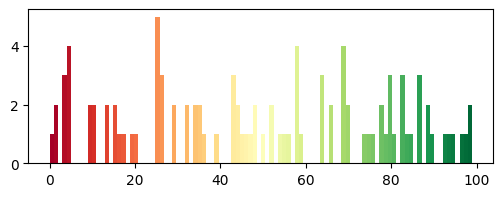

In [46]:
k = len(x)
rs_idx = [random.randint(0,k-1) for i in range(k)]

histogram(data = np.array(x)[rs_idx], 
          bins=k)

**random.randrange**

Cách thứ hai, ta dùng method random.randrange, nó cũng hoạt động theo cơ chế tương tự: Tuy nhiên nó không bao gồm index = k, do đó ta không cần dùng k-1

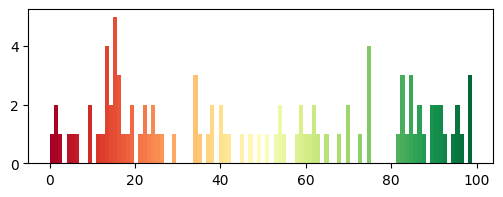

In [47]:
rs_idx = [random.randrange(0,k) for i in range(k)]

histogram(data = np.array(x)[rs_idx], bins=k)

**random.choice**

Cách làm thứ 3 là dùng method random.choice. Như ta thấy, cả 3 cách làm trên đều chỉ sinh ra mỗi lần 1 giá trị index ngẫu nhiên, do đó ta phải kết hợp thêm list comprehension để tạo ra danh sách index đầy đủ.

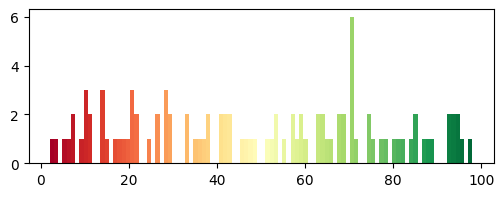

In [42]:
rs_idx = [random.choice(range(0,k)) for i in range(k)]

histogram(data = np.array(x)[rs_idx], bins=k)

**random.uniform**

Một cách làm khác, hơi kì dị đó là dùng bộ sinh giá trị ngẫu nhiên cho phân phối đồng dạng (uniform). Lưu ý: do phân phối đồng dạng là một phân phối liên tục nên giá trị mà nó xuất ra là float number, ta cần chuyển thành integer thông qua hàm int() để làm tròn giá trị thành số nguyên - để có thể sử dụng như index.

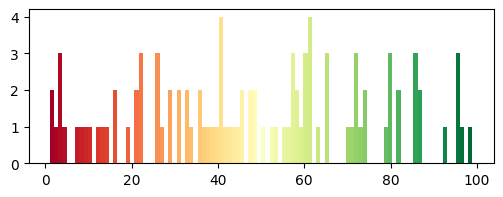

In [51]:
rs_idx = [int(random.uniform(0,k)) for i in range(k)]

histogram(data = np.array(x)[rs_idx], bins=k)

**random.choices**

Tuy nhiên, cách làm tối ưu nhất là method random.choices (chú ý chữ s), nó áp dụng trực tiếp lên list/array x và sẽ xuất ra ngay mẫu ngẫu nhiên mà ta cần:

Đây là cách làm chính thức và phổ biến được dùng bởi nhiều tác giả khi lập trình bootstrap.

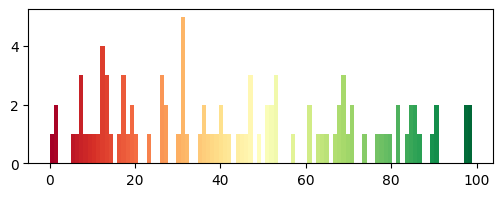

In [52]:
rsx = random.choices(x, k = 100)

histogram(data = rsx, bins=len(rsx))

Lưu ý; ta không thể dùng method random.sample, bởi vì nó hoạt động theo cơ chế KHÔNG hoàn lại, ta chỉ hoán đổi vị trí các phần tử trong danh sách x, nhưng đây không phải là bootstrap !

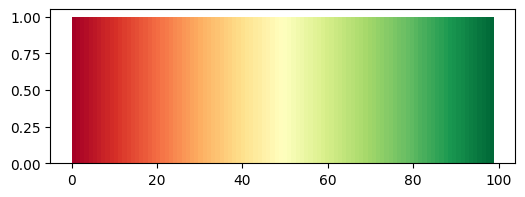

In [112]:
rsx_wor = random.sample(x.tolist(), k = 100)

histogram(data = rsx_wor, bins=len(rsx))

# Numpy

**numpy.randint**

Tiếp theo, ta sẽ dùng numpy, để đồng bộ ta chuyển x từ list thành np.array 1 chiều; method np.random.randint sẽ tạo ra danh sách k con số index ngẫu nhiên trong khoảng 0,k, bao gồm cả 0 và k, có hoàn lại; sau đó áp dụng index này cho array gốc, ta sinh ra được mẫu ngẫu nhiên cần thiết

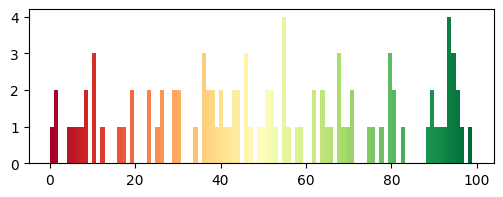

In [53]:
x = np.array(x)

rs_idx = np.random.randint(0,k,k)

histogram(data = x[rs_idx], bins=len(rsx))

**np.random.choice**

Numpy cung cấp method random.choice tương đương với random.choices mặc định của Python:

Đây là cách làm chính thức và hiệu quả nhất khi lập trình bootstrap với numpy array.

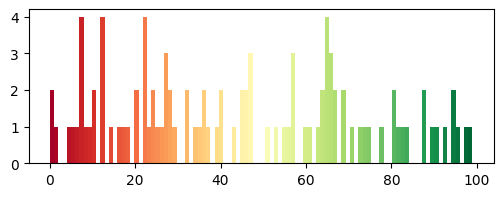

In [141]:
rsx = np.random.choice(x,size = k, replace=True)

histogram(data = rsx, bins=len(rsx))

Lưu ý: Phần sau đây chạy trên GPU, nên nếu máy tính của bạn không có GPU thì không cần quan tâm:

# Pytorch

Nếu muốn lập trình bootstrap sử dụng GPU, ta có 3 giải pháp: pytorch, tensorflow và cupy;

Pytorch sử dụng cấu trúc dữ liệu là tensor; ta sẽ dùng con đường phân phối multinomial của pytorch.

Nhi viết 1 hàm như bên dưới, hàm này sẽ sinh ra danh sách index của tensor, sau đó dùng index này để chọn mẫu.

In [54]:
def torch_boot_idx(pop_size, num_samples):
    p = torch.ones(pop_size, device='cuda') / pop_size
    return p.multinomial(num_samples=num_samples, replacement=True)

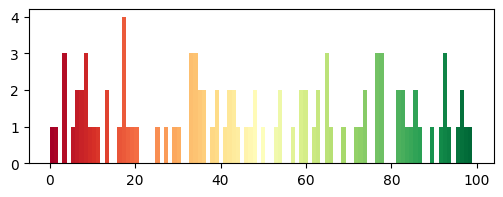

In [57]:
tor_idx = torch_boot_idx(pop_size = k, num_samples = k)

torch_x = torch.tensor(x, device = 'cuda') # Lưu ý: đang dùng GPU

histogram(data = torch_x[tor_idx].cpu().detach().numpy(), 
          bins=k)

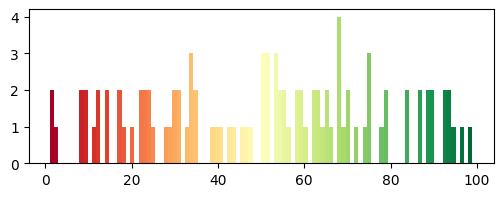

In [236]:
tor_idx = torch.randint(0,k,size = (k,), device = 'cuda')

histogram(data = torch_x[tor_idx].cpu().detach().numpy(), 
          bins=k)

# Tensorflow

Khi dùng thư viện tensorflow, ta có thể đi theo con đường phân phối uniform như sau:

In [58]:
tf_x = tf.convert_to_tensor(x)

tf_x

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])>

In [59]:
tf_idx = tf.random.uniform((k,), minval=0, maxval=k, dtype = tf.dtypes.int32)

tf_idx

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([20, 33, 18, 20, 65, 20, 26, 14, 39, 85, 85, 28,  0, 44, 72, 45, 97,
       94, 86, 36, 99, 40, 93, 30, 97, 47, 12, 38, 99,  6, 29, 30, 96, 62,
       71, 15, 48, 29, 84, 52, 93, 46, 48, 57, 44, 74, 13, 31,  8, 10, 98,
       95, 59, 47, 85, 76, 93, 24, 79, 87, 49, 89, 35, 95, 79, 39, 15, 85,
       19, 61, 52, 25,  9, 48, 58, 79, 87, 88, 31, 93, 32, 48, 11, 49, 66,
       22, 69, 14, 85, 90, 26, 16, 64, 39, 49,  5, 62, 81, 23, 12])>

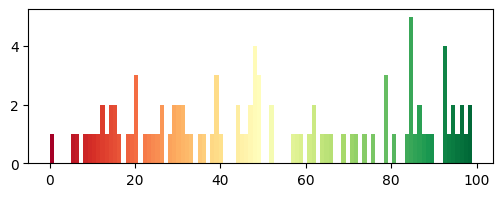

In [60]:
histogram(data = tf_x.numpy()[tf_idx], 
          bins=k)

# cupy

cupy được xem như phiên bản của numpy nhưng chạy trên GPU, nó cung cấp hầu hết những method với cú pháp và tên gọi giống y như trong numpy, nhưng tốc độ thi hành nhanh hơn khi dùng cho dữ liệu lớn:

In [61]:
gpu_x = cp.asarray(x)

gpu_x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [62]:
cp_rsx = cp.random.choice(gpu_x, size=k, replace=True)

cp_rsx

array([77, 71,  3, 60, 82, 61, 28, 60, 39, 33, 57, 21,  9, 31, 89, 35, 89,
       14, 14, 38,  8, 37, 12, 25, 26, 14, 96, 86,  1, 93, 50, 62, 60, 47,
       99, 49, 51, 19, 87, 55, 44, 45, 32, 31, 42, 67, 38, 56, 34, 71, 71,
       47, 88, 59, 81, 55, 48, 39,  3, 64, 42,  6, 57, 72, 72,  8, 60, 14,
       77, 30,  7, 60, 23, 51, 52, 36, 68, 12, 69, 95, 90, 66, 60, 76, 78,
       87,  6, 55, 65, 12, 87, 30, 61, 39, 72, 51, 51, 73, 71, 12])

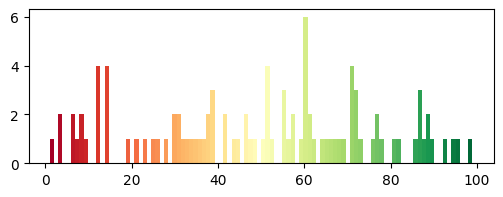

In [63]:
histogram(data = cp.asnumpy(cp_rsx), bins=k)

# Pandas

Cuối cùng, ta có pandas là một thư viện cấp cao, quy trình chọn mẫu ngẫu nhiên có hoàn lại trong pandas được thực hiện giản dị bằng method sample, cho cả pd.Series và pd.Dataframe.

Đây là cách làm đơn giản và được ưa chuộng bởi hầu hết chuyên viên thống kê, do dữ liệu đầu vào thường cũng là pandas dataframe. Tuy nhiên hiệu năng về tốc độ của pandas không hiệu quả bằng 3 thư viện dùng GPU ở trên.

In [65]:
# pandas series

pd_x = pd.Series(x)

pd_x

0      0
1      1
2      2
3      3
4      4
      ..
95    95
96    96
97    97
98    98
99    99
Length: 100, dtype: int32

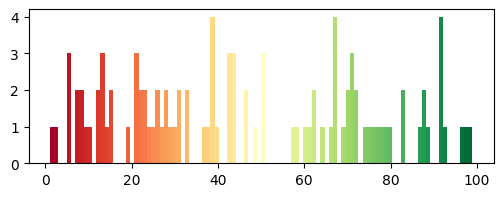

In [66]:
pd_rsx = pd_x.sample(n = k, replace = True)

histogram(data = pd_rsx, bins=k)

# Tổng kết

Nhi xin được tóm tắt những thông điệp chính từ bài này:

1) Sinh mẫu ngẫu nhiên là bộ phận cơ bản và quan trọng nhất trong chương trình bootstrap, ta nên thiết kế nó như 1 hàm riêng

2) Ta có thể tiến hành lấy mẫu ngẫu nhiên một cách sơ cấp, thông qua hệ thống index của array, hoặc dùng những method cao cấp như np.choice, hay pd.Series.sample

3) Có thể tiến hành cả 2 quy trình sinh mẫu ngẫu nhiên và tính toán thống kê trên GPU, bằng 3 thư viện: tensorflow, pytorch hay cupy

Một hàm sinh mẫu ngẫu nhiên tốt cần đáp ứng những tiêu chí như sau:

1) Đảm bảo tính ngẫu nhiên của quá trình chọn mẫu;

2) Thỏa mãn tính chất Có hoàn lại: một phần tử trong tập dữ liệu gốc có thể tái hiện diện nhiều lần trong mẫu được chọn;

3) Cho phép áp dụng thêm những điều kiện nâng cao, thí dụ trọng số xác suất;

4) Hiệu năng về tốc độ thi hành, điều này quan trọng hơn ta nghĩ, vì quy trình sinh mẫu ngẫu nhiên này sẽ phải lặp lại hàng ngàn lần, nên cần được tối ưu hóa về tốc độ khi dữ liệu gốc có kích thước rất lớn. Hiệu năng về thời gian của quy trình chọn mẫu ngẫu nhiên phụ thuộc vào 2 tham số là kích thước của dữ liệu gốc (n), kích thước mẫu (k). Bootstrap là trường hợp đặc biệt khi n = k, nên ước tính trung bình có lẽ là O(n * logn).

Để tăng tốc độ thi hành trên thực tế trong Python, chúng ta thường có 3 giải pháp:

+ Sử dụng các thư viện cấp thấp hoặc cấp cao viết bằng ngôn ngữ C, thí dụ pandas, numpy
+ Sử dụng tính toán song song trên nhiều CPU (multithreading)
+ Sử dụng các thư viện tính toán trên GPU 

Bài thực hành tạm dừng, chúc các bạn thực hành vui.